In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
from pathlib import Path
path = str(Path.cwd().parent.absolute())
sys.path.insert(0, path)
from libraries.functions import *
from libraries.particles import *

/home/vturino/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
ref_name = "kinematic_mu0.13_basalt7.5km_sed1km_cttV"
weak_name = "kinematic_mu0.05_basalt7.5km_sed1km_cttV"
strong_name = "kinematic_mu0.2_basalt7.5km_sed1km_cttV"

models_loc = '/home/vturino/Vale_nas/exhumation/raw_outputs/'
csvs_loc = '/home/vturino/Vale_nas/exhumation/gz_outputs/'
plot_loc = f"/home/vturino/PhD/projects/exhumation/plots/single_models/"

t = 45

ref = pd.read_parquet(f"{csvs_loc}{ref_name}/fields/full.{2*t}.gzip")
weak = pd.read_parquet(f"{csvs_loc}{weak_name}/fields/full.{2*t}.gzip")
strong = pd.read_parquet(f"{csvs_loc}{strong_name}/fields/full.{2*t}.gzip")

ref["compo"] = ref["sed"] + ref["oc"]
weak["compo"] = weak["sed"] + weak["oc"]
strong["compo"] = strong["sed"] + strong["oc"]



In [3]:

# find trench
ref_pts = get_points_with_y_in(ref, 15.e3, 2.e3, ymax=900.e3)
ref_trench = get_trench_position(ref_pts, threshold=0.13e7)

weak_pts = get_points_with_y_in(weak, 15.e3, 2.e3, ymax=900.e3)
weak_trench = get_trench_position(weak_pts, threshold=0.13e7)

strong_pts = get_points_with_y_in(strong, 15.e3, 2.e3, ymax=900.e3)
strong_trench = get_trench_position(strong_pts, threshold=0.13e7)


ref = ref[ref["compo"] > 0.01]
weak = weak[weak["compo"] > 0.01]
strong = strong[strong["compo"] > 0.01]



ref = ref[(ref["Points:0"] >= ref_trench -150.e3) & (ref["Points:0"] <= ref_trench + 100.e3) & (ref["Points:1"] >= ref["Points:1"].max() - 100.e3)]
weak = weak[(weak["Points:0"] >= weak_trench -150.e3) & (weak["Points:0"] <= weak_trench + 100.e3) & (weak["Points:1"] >= weak["Points:1"].max() - 100.e3)]
strong = strong[(strong["Points:0"] >= strong_trench -150.e3) & (strong["Points:0"] <= strong_trench + 100.e3) & (strong["Points:1"] >= strong["Points:1"].max() - 100.e3)]



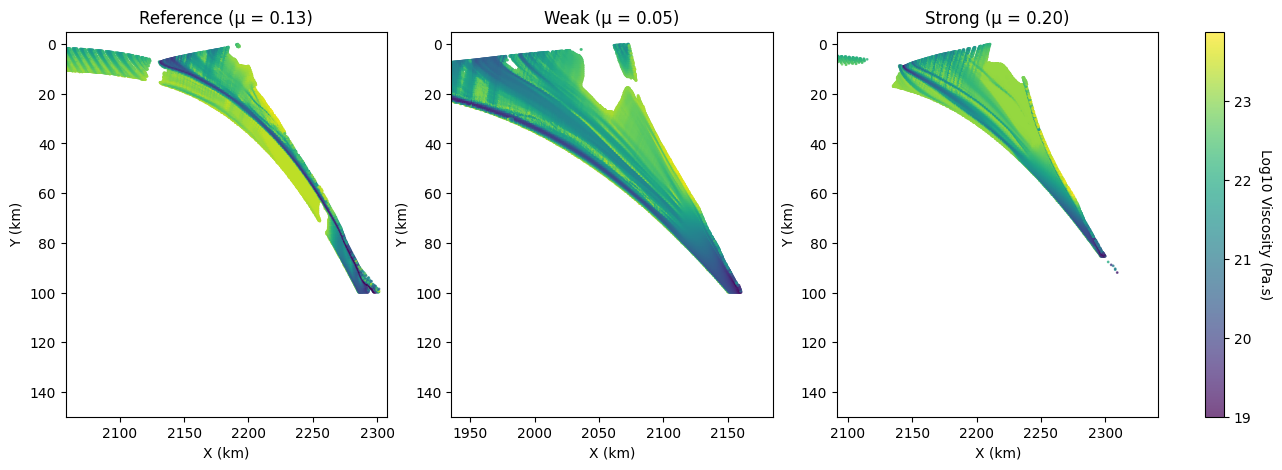

In [52]:
# define the plate interface as the area where the strain rate is above a certain threshold
SR = 1e-16  # strain rate threshold
pi_ref = ref[ref["strain_rate"] > SR]
pi_weak = weak[weak["strain_rate"] >    SR]
pi_strong = strong[strong["strain_rate"] >  SR]

# plot the plate interface using scatter plot for viscosity distribution
def plot_plate_interface(df, ax, label, trench=2500):
    x = df["Points:0"]/1.e3
    y = (df["Points:1"].max() - df["Points:1"])/1.e3
    z = np.log10(df.viscosity)
    trench = trench/1.e3

    scatter = ax.scatter(x, y, c=z, cmap='viridis', s=1, alpha=0.7)
    ax.set_title(label)
    ax.set_xlabel("X (km)")
    ax.set_ylabel("Y (km)")
    ax.set_xlim(trench - 150, trench + 100)
    ax.set_ylim(150, -5)

    return scatter

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plot_plate_interface(pi_ref, axs[0], "Reference (μ = 0.13)", ref_trench)
plot_plate_interface(pi_weak, axs[1], "Weak (μ = 0.05)", weak_trench)
plot_plate_interface(pi_strong, axs[2], "Strong (μ = 0.20)", strong_trench)
# Add colorbar
cbar = fig.colorbar(axs[0].collections[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Log10 Viscosity (Pa.s)', rotation=270, labelpad=15)


In [54]:
def geometric_mean(viscosity_array):
    return np.exp(np.mean(np.log(viscosity_array[viscosity_array > 0])))

print("Geometric mean viscosities (Pa·s):")
print(f"Reference: {geometric_mean(pi_ref['viscosity']):.1e}")
print(f"Weak:      {geometric_mean(pi_weak['viscosity']):.1e}")
print(f"Strong:    {geometric_mean(pi_strong['viscosity']):.1e}")


Geometric mean viscosities (Pa·s):
Reference: 1.9e+22
Weak:      9.1e+21
Strong:    3.5e+22


In [55]:
def weighted_geometric_mean(viscosity_array, weight_array):
    mask = (viscosity_array > 0) & (weight_array > 0)
    visco = viscosity_array[mask]
    weights = weight_array[mask]
    return np.exp(np.sum(weights * np.log(visco)) / np.sum(weights))

In [58]:
dx, dy = 100, 100  # cell sizes in meters
area_per_cell = dx * dy  # area of each cell

areas_ref = np.full(len(pi_ref), area_per_cell)
areas_weak = np.full(len(pi_weak), area_per_cell)
areas_strong = np.full(len(pi_strong), area_per_cell)


wgmean_ref = weighted_geometric_mean(pi_ref['viscosity'].values, areas_ref)
wgmean_weak = weighted_geometric_mean(pi_weak['viscosity'].values, areas_weak)
wgmean_strong = weighted_geometric_mean(pi_strong['viscosity'].values, areas_strong)

print("Weighted geometric mean viscosities (Pa·s):")
print(f"Reference: {wgmean_ref:.1e}")
print(f"Weak:      {wgmean_weak:.1e}")
print(f"Strong:    {wgmean_strong:.1e}")


Weighted geometric mean viscosities (Pa·s):
Reference: 1.9e+22
Weak:      9.1e+21
Strong:    3.5e+22


In [59]:
# % of weaker of weak, % of stronger of strong
def percentage_difference(ref_value, target_value):
    return (target_value - ref_value) / ref_value * 100
print("Percentage differences:")
print(f"Weak vs Reference: {percentage_difference(wgmean_ref, wgmean_weak):.1f}%")
print(f"Strong vs Reference: {percentage_difference(wgmean_ref, wgmean_strong):.1f}%")

Percentage differences:
Weak vs Reference: -52.2%
Strong vs Reference: 83.1%


In [61]:
#% of plate interface below a certain viscosity threshold
def percentage_below_threshold(df, threshold):
    return np.sum(df['viscosity'] < threshold) / len(df) * 100
threshold = 1e21  # viscosity threshold in Pa.s
print("Percentage of plate interface below threshold viscosity:")
print(f"Reference: {percentage_below_threshold(pi_ref, threshold):.1f}%")
print(f"Weak:      {percentage_below_threshold(pi_weak, threshold):.1f}%")
print(f"Strong:    {percentage_below_threshold(pi_strong, threshold):.1f}%")

Percentage of plate interface below threshold viscosity:
Reference: 14.6%
Weak:      12.1%
Strong:    5.5%
